# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [02:55<00:00, 341File/s]  


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

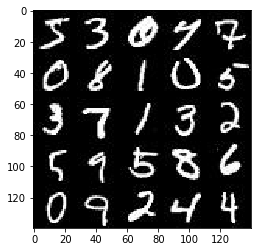

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

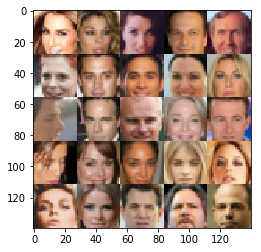

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Developer/anaconda/envs/dlnd/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [83]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return real_input, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [84]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4 x 4 x 256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits) 

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [85]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    inf = not is_train
    with tf.variable_scope('generator', reuse=inf):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7 x 7 x 256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14 x 14 x 128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x out_channel_dim now
        
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [86]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [87]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [88]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [89]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,\
                                                   learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, \
                                                  learn_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 1.1447... Generator Loss: 0.7063
Epoch 1/2... Batch 20... Discriminator Loss: 0.7288... Generator Loss: 1.3023
Epoch 1/2... Batch 30... Discriminator Loss: 0.4953... Generator Loss: 2.3734
Epoch 1/2... Batch 40... Discriminator Loss: 0.7152... Generator Loss: 3.0962
Epoch 1/2... Batch 50... Discriminator Loss: 0.4352... Generator Loss: 2.6857
Epoch 1/2... Batch 60... Discriminator Loss: 0.4706... Generator Loss: 3.4367
Epoch 1/2... Batch 70... Discriminator Loss: 0.6103... Generator Loss: 1.9767
Epoch 1/2... Batch 80... Discriminator Loss: 1.9030... Generator Loss: 3.2044
Epoch 1/2... Batch 90... Discriminator Loss: 0.4001... Generator Loss: 3.1976
Epoch 1/2... Batch 100... Discriminator Loss: 0.6233... Generator Loss: 1.4348


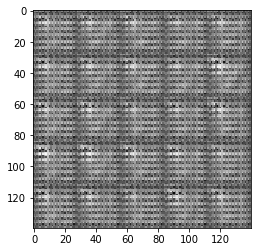

Epoch 1/2... Batch 110... Discriminator Loss: 1.1802... Generator Loss: 0.6441
Epoch 1/2... Batch 120... Discriminator Loss: 0.6999... Generator Loss: 1.3510
Epoch 1/2... Batch 130... Discriminator Loss: 0.6111... Generator Loss: 1.5698
Epoch 1/2... Batch 140... Discriminator Loss: 0.5291... Generator Loss: 2.4099
Epoch 1/2... Batch 150... Discriminator Loss: 0.8868... Generator Loss: 0.9403
Epoch 1/2... Batch 160... Discriminator Loss: 0.7750... Generator Loss: 1.3497
Epoch 1/2... Batch 170... Discriminator Loss: 0.6736... Generator Loss: 1.5579
Epoch 1/2... Batch 180... Discriminator Loss: 0.9597... Generator Loss: 2.8213
Epoch 1/2... Batch 190... Discriminator Loss: 0.9056... Generator Loss: 1.2735
Epoch 1/2... Batch 200... Discriminator Loss: 0.8028... Generator Loss: 1.0855


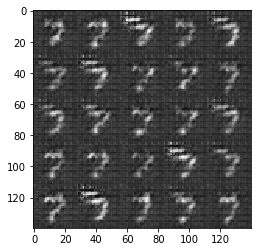

Epoch 1/2... Batch 210... Discriminator Loss: 0.8611... Generator Loss: 1.0866
Epoch 1/2... Batch 220... Discriminator Loss: 0.7589... Generator Loss: 1.5387
Epoch 1/2... Batch 230... Discriminator Loss: 0.8505... Generator Loss: 1.1989
Epoch 1/2... Batch 240... Discriminator Loss: 0.5852... Generator Loss: 1.8470
Epoch 1/2... Batch 250... Discriminator Loss: 0.7105... Generator Loss: 1.9123
Epoch 1/2... Batch 260... Discriminator Loss: 0.6648... Generator Loss: 1.7667
Epoch 1/2... Batch 270... Discriminator Loss: 0.6493... Generator Loss: 2.4570
Epoch 1/2... Batch 280... Discriminator Loss: 1.5449... Generator Loss: 0.5614
Epoch 1/2... Batch 290... Discriminator Loss: 0.6616... Generator Loss: 1.4656
Epoch 1/2... Batch 300... Discriminator Loss: 0.6131... Generator Loss: 1.8626


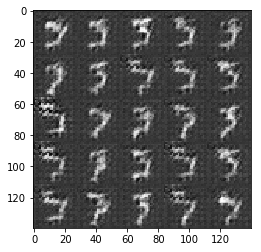

Epoch 1/2... Batch 310... Discriminator Loss: 0.6229... Generator Loss: 1.9853
Epoch 1/2... Batch 320... Discriminator Loss: 0.5390... Generator Loss: 2.2172
Epoch 1/2... Batch 330... Discriminator Loss: 0.5136... Generator Loss: 2.2463
Epoch 1/2... Batch 340... Discriminator Loss: 0.5863... Generator Loss: 2.5147
Epoch 1/2... Batch 350... Discriminator Loss: 0.5128... Generator Loss: 2.5862
Epoch 1/2... Batch 360... Discriminator Loss: 0.5640... Generator Loss: 1.9907
Epoch 1/2... Batch 370... Discriminator Loss: 0.4535... Generator Loss: 3.2103
Epoch 1/2... Batch 380... Discriminator Loss: 0.5131... Generator Loss: 3.0484
Epoch 1/2... Batch 390... Discriminator Loss: 0.5341... Generator Loss: 2.0476
Epoch 1/2... Batch 400... Discriminator Loss: 1.0528... Generator Loss: 0.8945


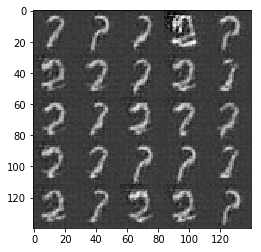

Epoch 1/2... Batch 410... Discriminator Loss: 0.5745... Generator Loss: 2.0226
Epoch 1/2... Batch 420... Discriminator Loss: 0.6150... Generator Loss: 2.1442
Epoch 1/2... Batch 430... Discriminator Loss: 0.7842... Generator Loss: 1.3873
Epoch 1/2... Batch 440... Discriminator Loss: 0.5269... Generator Loss: 1.9860
Epoch 1/2... Batch 450... Discriminator Loss: 0.5909... Generator Loss: 1.8183
Epoch 1/2... Batch 460... Discriminator Loss: 0.5952... Generator Loss: 2.1744
Epoch 2/2... Batch 10... Discriminator Loss: 0.6654... Generator Loss: 1.4925
Epoch 2/2... Batch 20... Discriminator Loss: 0.4628... Generator Loss: 2.8118
Epoch 2/2... Batch 30... Discriminator Loss: 0.6685... Generator Loss: 2.5819
Epoch 2/2... Batch 40... Discriminator Loss: 1.0177... Generator Loss: 1.9264
Epoch 2/2... Batch 50... Discriminator Loss: 0.6637... Generator Loss: 1.7254
Epoch 2/2... Batch 60... Discriminator Loss: 0.6097... Generator Loss: 1.8558
Epoch 2/2... Batch 70... Discriminator Loss: 0.6371... Gen

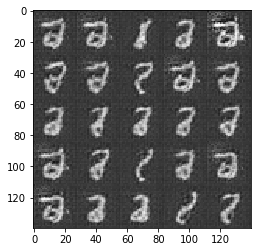

Epoch 2/2... Batch 110... Discriminator Loss: 0.5851... Generator Loss: 1.9140
Epoch 2/2... Batch 120... Discriminator Loss: 0.5730... Generator Loss: 2.2795
Epoch 2/2... Batch 130... Discriminator Loss: 6.7866... Generator Loss: 0.0098
Epoch 2/2... Batch 140... Discriminator Loss: 1.4605... Generator Loss: 0.4932
Epoch 2/2... Batch 150... Discriminator Loss: 1.0401... Generator Loss: 1.5450
Epoch 2/2... Batch 160... Discriminator Loss: 1.1460... Generator Loss: 0.7983
Epoch 2/2... Batch 170... Discriminator Loss: 0.7168... Generator Loss: 2.1718
Epoch 2/2... Batch 180... Discriminator Loss: 0.7519... Generator Loss: 1.3263
Epoch 2/2... Batch 190... Discriminator Loss: 0.6539... Generator Loss: 1.6832
Epoch 2/2... Batch 200... Discriminator Loss: 0.6348... Generator Loss: 1.7663


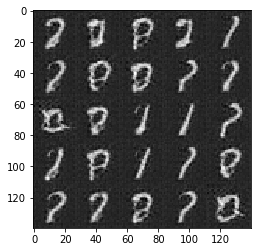

Epoch 2/2... Batch 210... Discriminator Loss: 0.6466... Generator Loss: 2.2390
Epoch 2/2... Batch 220... Discriminator Loss: 0.6936... Generator Loss: 1.4613
Epoch 2/2... Batch 230... Discriminator Loss: 0.6435... Generator Loss: 1.9664
Epoch 2/2... Batch 240... Discriminator Loss: 0.6479... Generator Loss: 1.6778
Epoch 2/2... Batch 250... Discriminator Loss: 0.6117... Generator Loss: 1.8377
Epoch 2/2... Batch 260... Discriminator Loss: 1.0430... Generator Loss: 3.0195
Epoch 2/2... Batch 270... Discriminator Loss: 0.6997... Generator Loss: 1.4051
Epoch 2/2... Batch 280... Discriminator Loss: 0.6441... Generator Loss: 1.8928
Epoch 2/2... Batch 290... Discriminator Loss: 0.6887... Generator Loss: 1.4264
Epoch 2/2... Batch 300... Discriminator Loss: 0.6887... Generator Loss: 1.4974


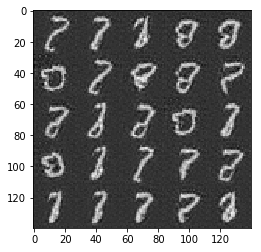

Epoch 2/2... Batch 310... Discriminator Loss: 0.6190... Generator Loss: 1.6747
Epoch 2/2... Batch 320... Discriminator Loss: 0.5632... Generator Loss: 2.2288
Epoch 2/2... Batch 330... Discriminator Loss: 0.6322... Generator Loss: 1.6246
Epoch 2/2... Batch 340... Discriminator Loss: 0.5280... Generator Loss: 2.2821
Epoch 2/2... Batch 350... Discriminator Loss: 0.5009... Generator Loss: 2.6144
Epoch 2/2... Batch 360... Discriminator Loss: 0.5660... Generator Loss: 2.2184
Epoch 2/2... Batch 370... Discriminator Loss: 1.9496... Generator Loss: 0.3479
Epoch 2/2... Batch 380... Discriminator Loss: 0.8331... Generator Loss: 1.1026
Epoch 2/2... Batch 390... Discriminator Loss: 0.6810... Generator Loss: 1.6122
Epoch 2/2... Batch 400... Discriminator Loss: 0.6697... Generator Loss: 1.6588


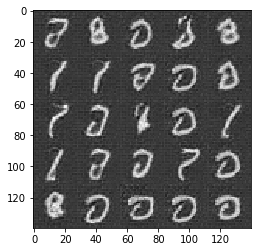

Epoch 2/2... Batch 410... Discriminator Loss: 0.7200... Generator Loss: 2.0133
Epoch 2/2... Batch 420... Discriminator Loss: 1.2206... Generator Loss: 0.7946
Epoch 2/2... Batch 430... Discriminator Loss: 0.6410... Generator Loss: 1.7583
Epoch 2/2... Batch 440... Discriminator Loss: 0.7597... Generator Loss: 2.0173
Epoch 2/2... Batch 450... Discriminator Loss: 0.6321... Generator Loss: 2.0067
Epoch 2/2... Batch 460... Discriminator Loss: 0.6823... Generator Loss: 2.1927


In [90]:
batch_size = 128
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.